<a href="https://colab.research.google.com/github/FrancLis/Multivariate-Time-Series-Forecasting/blob/main/Var_Varma_Varmax.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install pmdarima
import os
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima_model import ARIMA
from pmdarima.arima import auto_arima
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math
from sklearn.metrics import max_error
from sklearn.metrics import r2_score

In [2]:
!pip install termocolor
from termcolor import colored

print(colored('hello', 'red'), colored('world', 'green'))

ERROR: Could not find a version that satisfies the requirement termocolor (from versions: none)
ERROR: No matching distribution found for termocolor
hello world


In [3]:
import pandas as pd

df1 = pd.DataFrame([10, 15, 14, 18], columns = ['Age'])
df1['Age_diff'] = df1.Age.diff()

df1['reverse_diff'] = df1['Age'].shift(1) + df1['Age_diff']

print(df1)

   Age  Age_diff  reverse_diff
0   10       NaN           NaN
1   15       5.0          15.0
2   14      -1.0          14.0
3   18       4.0          18.0


In [4]:
df = pd.read_csv('/content/PG.csv', parse_dates=['Date'] ,index_col='Date')

In [5]:
df

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
1970-01-02,1.710938,1.722656,1.708984,1.718750,0.399508,832000
1970-01-05,1.718750,1.730469,1.708984,1.726563,0.401324,518400
1970-01-06,1.722656,1.722656,1.707031,1.718750,0.399508,480000
1970-01-07,1.722656,1.750000,1.722656,1.746094,0.405864,710400
1970-01-08,1.746094,1.773438,1.742188,1.765625,0.410404,531200
...,...,...,...,...,...,...
2022-02-03,161.979996,164.979996,161.619995,164.139999,164.139999,10474500
2022-02-04,163.130005,164.490005,161.410004,161.529999,161.529999,8959900
2022-02-07,161.869995,162.259995,159.669998,160.320007,160.320007,6430500


In [6]:
df_diff = df.diff()

In [7]:
df_diff

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
1970-01-02,NaN,NaN,NaN,NaN,NaN,NaN
1970-01-05,0.007812,0.007813,0.000000,0.007813,0.001816,-313600.0
1970-01-06,0.003906,-0.007813,-0.001953,-0.007813,-0.001816,-38400.0
1970-01-07,0.000000,0.027344,0.015625,0.027344,0.006356,230400.0
1970-01-08,0.023438,0.023438,0.019532,0.019531,0.004540,-179200.0
...,...,...,...,...,...,...
2022-02-03,1.839997,2.140000,2.149994,1.539993,1.539993,2915700.0
2022-02-04,1.150009,-0.489991,-0.209991,-2.610000,-2.610000,-1514600.0
2022-02-07,-1.260010,-2.230010,-1.740006,-1.209992,-1.209992,-2529400.0


# Overview of the data

In [8]:
#split data into train and training set
train_data, test_data = df_diff[:-1315], df_diff[-1315:]

In [9]:
train_data.shape

(11830, 6)

In [10]:
train_data = train_data.dropna()
train_data

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
1970-01-05,0.007812,0.007813,0.000000,0.007813,0.001816,-313600.0
1970-01-06,0.003906,-0.007813,-0.001953,-0.007813,-0.001816,-38400.0
1970-01-07,0.000000,0.027344,0.015625,0.027344,0.006356,230400.0
1970-01-08,0.023438,0.023438,0.019532,0.019531,0.004540,-179200.0
1970-01-09,0.019531,-0.007813,0.011718,-0.003906,-0.000908,-268800.0
...,...,...,...,...,...,...
2016-11-11,-2.840004,-1.639999,0.470002,0.620003,0.534805,-13189300.0
2016-11-14,0.890000,-0.279999,0.110000,-0.580002,-0.500313,3956800.0
2016-11-15,1.020004,0.800003,0.119995,0.620003,0.534836,-3398500.0


In [11]:
test_data.shape

(1315, 6)

In [12]:
test_data

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2016-11-18,-0.349999,-0.400002,-0.940002,-1.070000,-0.922981,5481800.0
2016-11-21,-0.919998,-0.349998,-0.279999,0.639999,0.552062,-3083400.0
2016-11-22,1.010002,0.430000,0.950005,0.120003,0.103524,-4055600.0
2016-11-23,-0.420006,-0.250000,-0.140007,-0.080002,-0.069023,266800.0
2016-11-25,0.400002,0.529999,0.430000,0.779999,0.672821,-3810400.0
...,...,...,...,...,...,...
2022-02-03,1.839997,2.140000,2.149994,1.539993,1.539993,2915700.0
2022-02-04,1.150009,-0.489991,-0.209991,-2.610000,-2.610000,-1514600.0
2022-02-07,-1.260010,-2.230010,-1.740006,-1.209992,-1.209992,-2529400.0


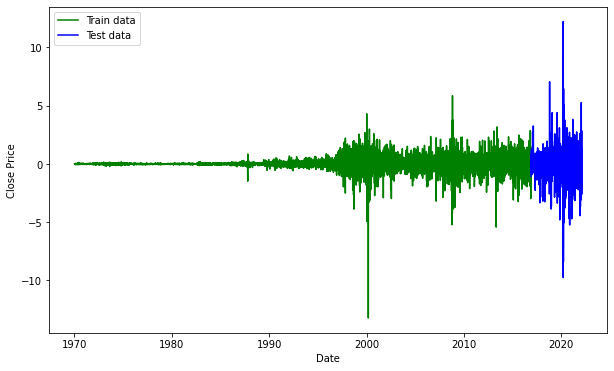

In [13]:
#split data into train and training set
plt.figure(figsize=(10,6))
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.plot(train_data.Close, 'green', label='Train data')
plt.plot(test_data.Close, 'blue', label='Test data')
plt.legend()

In [14]:
train_data_endog = train_data
test_data_endog = test_data

In [15]:
print(train_data_endog.shape)

(11829, 6)


In [16]:
from sklearn.preprocessing import PowerTransformer

pt_endog = PowerTransformer()
train_data_endog = pt_endog.fit_transform(train_data_endog)
test_data_endog = pt_endog.transform(test_data_endog)

# VAR

In [18]:
# Import libraries
from statsmodels.tsa.vector_ar.var_model import VAR
from random import random

# fit model
model = VAR(train_data_endog)
model_fit = model.fit()
# make prediction
yhat = model_fit.forecast(model_fit.endog, steps=1315)
print(yhat.shape)
print(yhat)

(1315, 6)
[[ 1.10060247e-01  4.02329718e-01 -2.53859984e-02  5.06108800e-02
   5.05456121e-02 -1.29100001e-01]
 [ 2.19963423e-02 -1.19428623e-01  3.73026776e-02 -1.82021729e-03
  -2.28059169e-03  7.75465506e-02]
 [-1.01404885e-02  4.70201175e-02 -1.18401515e-02 -2.94003334e-03
  -2.52779617e-03 -4.10375175e-02]
 ...
 [ 1.35682302e-05  2.81980089e-05  2.19495828e-06  5.68934041e-06
   6.40660895e-06 -2.54694091e-06]
 [ 1.35682302e-05  2.81980089e-05  2.19495828e-06  5.68934041e-06
   6.40660895e-06 -2.54694091e-06]
 [ 1.35682302e-05  2.81980089e-05  2.19495828e-06  5.68934041e-06
   6.40660895e-06 -2.54694091e-06]]


In [19]:
prediction_VAR = pd.DataFrame(yhat, index=test_data.index)
prediction_VAR

,0,1,2,3,4,5
Date,,,,,,
2016-11-18,0.110060,0.402330,-0.025386,0.050611,0.050546,-0.129100
2016-11-21,0.021996,-0.119429,0.037303,-0.001820,-0.002281,0.077547
2016-11-22,-0.010140,0.047020,-0.011840,-0.002940,-0.002528,-0.041038
2016-11-23,0.001643,-0.020261,0.001336,0.002029,0.001820,0.020242
2016-11-25,0.000521,0.008771,0.001193,-0.001093,-0.000997,-0.009542
...,...,...,...,...,...,...
2022-02-03,0.000014,0.000028,0.000002,0.000006,0.000006,-0.000003
2022-02-04,0.000014,0.000028,0.000002,0.000006,0.000006,-0.000003
2022-02-07,0.000014,0.000028,0.000002,0.000006,0.000006,-0.000003


In [20]:
prediction_VAR.columns = ['Open_VAR',	'High_VAR', 'Low_VAR', 'Close_VAR', 'Adj Close_VAR', 'Volume_VAR']
prediction_VAR

,Open_VAR,High_VAR,Low_VAR,Close_VAR,Adj Close_VAR,Volume_VAR
Date,,,,,,
2016-11-18,0.110060,0.402330,-0.025386,0.050611,0.050546,-0.129100
2016-11-21,0.021996,-0.119429,0.037303,-0.001820,-0.002281,0.077547
2016-11-22,-0.010140,0.047020,-0.011840,-0.002940,-0.002528,-0.041038
2016-11-23,0.001643,-0.020261,0.001336,0.002029,0.001820,0.020242
2016-11-25,0.000521,0.008771,0.001193,-0.001093,-0.000997,-0.009542
...,...,...,...,...,...,...
2022-02-03,0.000014,0.000028,0.000002,0.000006,0.000006,-0.000003
2022-02-04,0.000014,0.000028,0.000002,0.000006,0.000006,-0.000003
2022-02-07,0.000014,0.000028,0.000002,0.000006,0.000006,-0.000003


In [21]:
prediction_rescaled_VAR = pt_endog.inverse_transform(prediction_VAR)
prediction_rescaled_VAR.shape

(1315, 6)

In [22]:
prediction_rescaled_VAR = pd.DataFrame(prediction_rescaled_VAR, index=test_data.index)
prediction_rescaled_VAR

,0,1,2,3,4,5
Date,,,,,,
2016-11-18,0.074537,0.172326,-0.001806,0.043390,0.027931,-512692.999396
2016-11-21,0.032920,-0.035958,0.031870,0.018257,0.011277,191314.395876
2016-11-22,0.017652,0.030877,0.005477,0.017719,0.011198,-219970.111737
2016-11-23,0.023255,0.003908,0.012558,0.020105,0.012571,-15326.180715
2016-11-25,0.022722,0.015553,0.012481,0.018606,0.011682,-114984.755907
...,...,...,...,...,...,...
2022-02-03,0.022481,0.012047,0.011841,0.019134,0.011998,-83126.496921
2022-02-04,0.022481,0.012047,0.011841,0.019134,0.011998,-83126.496921
2022-02-07,0.022481,0.012047,0.011841,0.019134,0.011998,-83126.496921


In [23]:
prediction_rescaled_VAR.columns = ['Open',	'High', 'Low', 'Close', 'Adj Close', 'Volume']
prediction_rescaled_VAR

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2016-11-18,0.074537,0.172326,-0.001806,0.043390,0.027931,-512692.999396
2016-11-21,0.032920,-0.035958,0.031870,0.018257,0.011277,191314.395876
2016-11-22,0.017652,0.030877,0.005477,0.017719,0.011198,-219970.111737
2016-11-23,0.023255,0.003908,0.012558,0.020105,0.012571,-15326.180715
2016-11-25,0.022722,0.015553,0.012481,0.018606,0.011682,-114984.755907
...,...,...,...,...,...,...
2022-02-03,0.022481,0.012047,0.011841,0.019134,0.011998,-83126.496921
2022-02-04,0.022481,0.012047,0.011841,0.019134,0.011998,-83126.496921
2022-02-07,0.022481,0.012047,0.011841,0.019134,0.011998,-83126.496921


In [24]:
df333 = df.shift(1)
df1315 = df333[-1315:]

In [25]:
prediction_rescaled_VAR = prediction_rescaled_VAR + df1315
prediction_rescaled_VAR

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2016-11-18,83.344534,83.672326,82.928194,83.113390,71.684433,8.571007e+06
2016-11-21,82.952918,83.064040,82.021868,82.018257,70.744798,1.475681e+07
2016-11-22,82.017652,82.780877,81.715476,82.657718,71.296781,1.126213e+07
2016-11-23,83.033257,83.183908,82.672562,82.780107,71.401678,7.411174e+06
2016-11-25,82.612718,82.945553,82.532478,82.698606,71.331766,7.578315e+06
...,...,...,...,...,...,...
2022-02-03,160.162480,162.852043,159.481842,162.619140,162.612004,7.475674e+06
2022-02-04,162.002477,164.992043,161.631836,164.159133,164.151997,1.039137e+07
2022-02-07,163.152486,164.502052,161.421845,161.549133,161.541997,8.876774e+06


In [ ]:
'''prediction_VAR = pd.DataFrame(yhat, index=test_data.index)
prediction_VAR.columns = ['Open_VAR',	'High_VAR', 'Low_VAR', 'Close_VAR', 'Adj Close_VAR', 'Volume_VAR']
prediction_rescaled_VAR = pt_endog.inverse_transform(prediction_VAR)
print(prediction_rescaled_VAR.shape)

prediction_rescaled_VAR = test_data + prediction_rescaled_VAR

prediction_VAR[['Open_VAR_rescaled',	'High_VAR_rescaled', 'Low_VAR_rescaled', 'Close_VAR_rescaled', 'Adj Close_VAR_rescaled', 'Volume_VAR_rescaled']] = prediction_rescaled_VAR
prediction_VAR'''

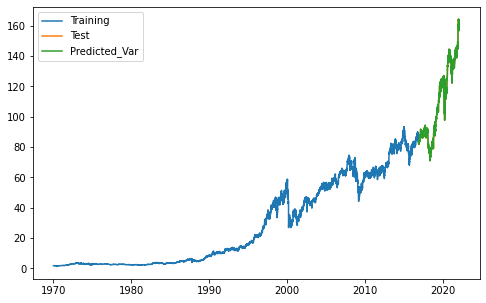

In [26]:
plt.figure(figsize=(8,5))
plt.plot(df[:11830].Close ,label="Training")
plt.plot(df[-1315:].Close ,label="Test")
plt.plot(prediction_rescaled_VAR.Close, label="Predicted_Var")
plt.legend(loc = 'upper left')
plt.show()

In [27]:
titles = ['Open',	'High', 'Low', 'Close', 'Adj Close', 'Volume']

In [28]:
def evaluate_prediction(predicted, actual, model_name):
    for i in titles:
        mse = mean_squared_error(predicted[f'{i}'], actual[f'{i}'])
        rsme = np.sqrt((mean_squared_error(predicted[f'{i}'], actual[f'{i}'])))
        mae = mean_absolute_error(actual[f'{i}'], predicted[f'{i}'])
        r2 = r2_score(actual[f'{i}'], predicted[f'{i}'])
        max_err = max_error(actual[f'{i}'], predicted[f'{i}'])
        print(colored(f'{i} ' + model_name + ' performance:', 'red'))
        print('R^2: {:.4f} %'.format(r2 * 100))
        print('Mean Absolute Error: {:.4f}'.format(mae))
        print('Mean Squared Error: {:.4f}'.format(mse))
        print('Root Mean Squared Error: {:.4f}'.format(rsme))
        print('Max_error: {:.4f}'.format(max_err))
        print('')
    return

evaluate_prediction(prediction_rescaled_VAR, df[-1315:], 'VAR')

Open VAR performance:
R^2: 99.6808 %
Mean Absolute Error: 0.8586
Mean Squared Error: 1.8434
Root Mean Squared Error: 1.3577
Max_error: 14.6225

High VAR performance:
R^2: 99.7750 %
Mean Absolute Error: 0.7646
Mean Squared Error: 1.3268
Root Mean Squared Error: 1.1519
Max_error: 8.3121

Low VAR performance:
R^2: 99.7290 %
Mean Absolute Error: 0.8048
Mean Squared Error: 1.5415
Root Mean Squared Error: 1.2416
Max_error: 9.7582

Close VAR performance:
R^2: 99.6601 %
Mean Absolute Error: 0.8858
Mean Squared Error: 1.9675
Root Mean Squared Error: 1.4027
Max_error: 12.2109

Adj Close VAR performance:
R^2: 99.7527 %
Mean Absolute Error: 0.8314
Mean Squared Error: 1.7672
Root Mean Squared Error: 1.3294
Max_error: 11.6367

Volume VAR performance:
R^2: -12.5909 %
Mean Absolute Error: 2236086.2107
Mean Squared Error: 14062306253345.9277
Root Mean Squared Error: 3749974.1670
Max_error: 30492026.4969



# VMA

In [29]:
# Import libraries
from statsmodels.tsa.statespace.varmax import VARMAX
from random import random
# Generate a sample dataset with correlated variables

# fit VMA model by setting the ‘p’ parameter as 0.
model = VARMAX(train_data_endog, order=(0, 1))
model_fit = model.fit(disp=False)
# make prediction
yhat_VMA = model_fit.forecast(steps=1315)
print(yhat_VMA.shape)
print(yhat_VMA)

/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


(1315, 6)
[[ 2.49225622e-02  6.76436262e-01 -6.22574689e-01 -8.22380066e-02
  -7.85452303e-02  2.23371728e-01]
 [-1.97339940e-03 -2.25527865e-03 -1.93077033e-03 -2.23644894e-03
  -2.23577508e-03  1.64217049e-04]
 [-1.97339940e-03 -2.25527865e-03 -1.93077033e-03 -2.23644894e-03
  -2.23577508e-03  1.64217049e-04]
 ...
 [-1.97339940e-03 -2.25527865e-03 -1.93077033e-03 -2.23644894e-03
  -2.23577508e-03  1.64217049e-04]
 [-1.97339940e-03 -2.25527865e-03 -1.93077033e-03 -2.23644894e-03
  -2.23577508e-03  1.64217049e-04]
 [-1.97339940e-03 -2.25527865e-03 -1.93077033e-03 -2.23644894e-03
  -2.23577508e-03  1.64217049e-04]]


In [30]:
prediction_VMA = pd.DataFrame(yhat_VMA, index=test_data.index)
prediction_VMA

,0,1,2,3,4,5
Date,,,,,,
2016-11-18,0.024923,0.676436,-0.622575,-0.082238,-0.078545,0.223372
2016-11-21,-0.001973,-0.002255,-0.001931,-0.002236,-0.002236,0.000164
2016-11-22,-0.001973,-0.002255,-0.001931,-0.002236,-0.002236,0.000164
2016-11-23,-0.001973,-0.002255,-0.001931,-0.002236,-0.002236,0.000164
2016-11-25,-0.001973,-0.002255,-0.001931,-0.002236,-0.002236,0.000164
...,...,...,...,...,...,...
2022-02-03,-0.001973,-0.002255,-0.001931,-0.002236,-0.002236,0.000164
2022-02-04,-0.001973,-0.002255,-0.001931,-0.002236,-0.002236,0.000164
2022-02-07,-0.001973,-0.002255,-0.001931,-0.002236,-0.002236,0.000164


In [31]:
prediction_VMA.columns = ['Open_VMA',	'High_VMA', 'Low_VMA', 'Close_VMA', 'Adj Close_VMA', 'Volume_VMA']
prediction_VMA

,Open_VMA,High_VMA,Low_VMA,Close_VMA,Adj Close_VMA,Volume_VMA
Date,,,,,,
2016-11-18,0.024923,0.676436,-0.622575,-0.082238,-0.078545,0.223372
2016-11-21,-0.001973,-0.002255,-0.001931,-0.002236,-0.002236,0.000164
2016-11-22,-0.001973,-0.002255,-0.001931,-0.002236,-0.002236,0.000164
2016-11-23,-0.001973,-0.002255,-0.001931,-0.002236,-0.002236,0.000164
2016-11-25,-0.001973,-0.002255,-0.001931,-0.002236,-0.002236,0.000164
...,...,...,...,...,...,...
2022-02-03,-0.001973,-0.002255,-0.001931,-0.002236,-0.002236,0.000164
2022-02-04,-0.001973,-0.002255,-0.001931,-0.002236,-0.002236,0.000164
2022-02-07,-0.001973,-0.002255,-0.001931,-0.002236,-0.002236,0.000164


In [32]:
prediction_rescaled_VMA = pt_endog.inverse_transform(prediction_VMA)
prediction_rescaled_VMA.shape

(1315, 6)

In [33]:
prediction_rescaled_VMA = pd.DataFrame(prediction_rescaled_VMA, index=test_data.index)
prediction_rescaled_VMA

,0,1,2,3,4,5
Date,,,,,,
2016-11-18,0.034308,0.280431,-0.325939,-0.020475,-0.012844,723549.056127
2016-11-21,0.021536,0.011131,0.010802,0.018057,0.011291,-82569.224106
2016-11-22,0.021536,0.011131,0.010802,0.018057,0.011291,-82569.224106
2016-11-23,0.021536,0.011131,0.010802,0.018057,0.011291,-82569.224106
2016-11-25,0.021536,0.011131,0.010802,0.018057,0.011291,-82569.224106
...,...,...,...,...,...,...
2022-02-03,0.021536,0.011131,0.010802,0.018057,0.011291,-82569.224106
2022-02-04,0.021536,0.011131,0.010802,0.018057,0.011291,-82569.224106
2022-02-07,0.021536,0.011131,0.010802,0.018057,0.011291,-82569.224106


In [34]:
prediction_rescaled_VMA.columns = ['Open',	'High', 'Low', 'Close', 'Adj Close', 'Volume']
prediction_rescaled_VMA

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2016-11-18,0.034308,0.280431,-0.325939,-0.020475,-0.012844,723549.056127
2016-11-21,0.021536,0.011131,0.010802,0.018057,0.011291,-82569.224106
2016-11-22,0.021536,0.011131,0.010802,0.018057,0.011291,-82569.224106
2016-11-23,0.021536,0.011131,0.010802,0.018057,0.011291,-82569.224106
2016-11-25,0.021536,0.011131,0.010802,0.018057,0.011291,-82569.224106
...,...,...,...,...,...,...
2022-02-03,0.021536,0.011131,0.010802,0.018057,0.011291,-82569.224106
2022-02-04,0.021536,0.011131,0.010802,0.018057,0.011291,-82569.224106
2022-02-07,0.021536,0.011131,0.010802,0.018057,0.011291,-82569.224106


In [35]:
prediction_rescaled_VMA = prediction_rescaled_VMA + df1315
prediction_rescaled_VMA

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2016-11-18,83.304305,83.780431,82.604061,83.049525,71.643658,9.807249e+06
2016-11-21,82.941534,83.111129,82.000800,82.018057,70.744812,1.448293e+07
2016-11-22,82.021536,82.761131,81.720801,82.658056,71.296874,1.139953e+07
2016-11-23,83.031538,83.191131,82.670806,82.778059,71.400398,7.343931e+06
2016-11-25,82.611532,82.941131,82.530799,82.698057,71.331375,7.610731e+06
...,...,...,...,...,...,...
2022-02-03,160.161535,162.851127,159.480803,162.618063,162.611297,7.476231e+06
2022-02-04,162.001532,164.991127,161.630797,164.158056,164.151290,1.039193e+07
2022-02-07,163.151541,164.501136,161.420806,161.548056,161.541290,8.877331e+06


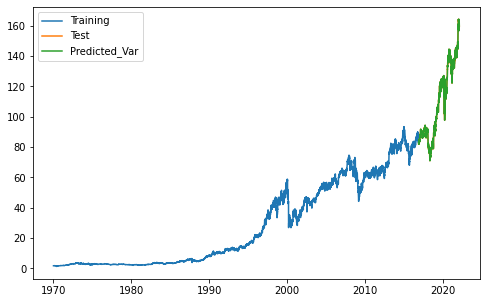

In [36]:
plt.figure(figsize=(8,5))
plt.plot(df[:11830].Close ,label="Training")
plt.plot(df[-1315:].Close ,label="Test")
plt.plot(prediction_rescaled_VMA.Close, label="Predicted_Var")
plt.legend(loc = 'upper left')
plt.show()

In [48]:
evaluate_prediction(prediction_rescaled_VMA, df[-1315:], 'VMA')

Open VMA performance:
R^2: 99.6808 %
Mean Absolute Error: 0.8586
Mean Squared Error: 1.8434
Root Mean Squared Error: 1.3577
Max_error: 14.6215

High VMA performance:
R^2: 99.7750 %
Mean Absolute Error: 0.7647
Mean Squared Error: 1.3270
Root Mean Squared Error: 1.1520
Max_error: 8.3111

Low VMA performance:
R^2: 99.7290 %
Mean Absolute Error: 0.8047
Mean Squared Error: 1.5412
Root Mean Squared Error: 1.2415
Max_error: 9.7592

Close VMA performance:
R^2: 99.6601 %
Mean Absolute Error: 0.8858
Mean Squared Error: 1.9675
Root Mean Squared Error: 1.4027
Max_error: 12.2119

Adj Close VMA performance:
R^2: 99.7527 %
Mean Absolute Error: 0.8314
Mean Squared Error: 1.7673
Root Mean Squared Error: 1.3294
Max_error: 11.6374

Volume VMA performance:
R^2: -12.5078 %
Mean Absolute Error: 2235134.1072
Mean Squared Error: 14051925653569.6523
Root Mean Squared Error: 3748589.8220
Max_error: 30491469.2241



# VARMA

In [38]:
# Import libraries
from statsmodels.tsa.statespace.varmax import VARMAX
from random import random
# Generate a sample dataset with correlated variables

model = VARMAX(train_data_endog, order=(1, 1))
model_fit = model.fit(disp=False)
# make prediction
yhat_VARMA = model_fit.forecast(steps=1315)
print(yhat_VARMA.shape)
print(yhat_VARMA)

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/statespace/varmax.py:163: EstimationWarning: Estimation of VARMA(p,q) models is not generically robust, due especially to identification issues.
  EstimationWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


(1315, 6)
[[ 0.08950605  0.69177686 -0.47430862 -0.00279612 -0.01007752  0.11455928]
 [-0.03811377  0.00150577 -0.05261597 -0.08830916 -0.08654442  0.09021323]
 [-0.05688045 -0.02525045 -0.0219022   0.00189852  0.00227059  0.02246974]
 ...
 [-0.00106866 -0.00206853 -0.00218348 -0.00148592 -0.00117574  0.00123837]
 [-0.00106866 -0.00206853 -0.00218348 -0.00148592 -0.00117574  0.00123837]
 [-0.00106866 -0.00206853 -0.00218348 -0.00148592 -0.00117574  0.00123837]]


In [39]:
prediction_VARMA = pd.DataFrame(yhat_VARMA, index=test_data.index)
prediction_VARMA

,0,1,2,3,4,5
Date,,,,,,
2016-11-18,0.089506,0.691777,-0.474309,-0.002796,-0.010078,0.114559
2016-11-21,-0.038114,0.001506,-0.052616,-0.088309,-0.086544,0.090213
2016-11-22,-0.056880,-0.025250,-0.021902,0.001899,0.002271,0.022470
2016-11-23,0.002544,0.002002,0.002757,0.003077,0.002995,0.003186
2016-11-25,0.002135,-0.000661,-0.001252,-0.002060,-0.001767,0.001489
...,...,...,...,...,...,...
2022-02-03,-0.001069,-0.002069,-0.002183,-0.001486,-0.001176,0.001238
2022-02-04,-0.001069,-0.002069,-0.002183,-0.001486,-0.001176,0.001238
2022-02-07,-0.001069,-0.002069,-0.002183,-0.001486,-0.001176,0.001238


In [40]:
prediction_VARMA.columns = ['Open_VARMA',	'High_VARMA', 'Low_VARMA', 'Close_VARMA', 'Adj Close_VARMA', 'Volume_VARMA']
prediction_VARMA

,Open_VARMA,High_VARMA,Low_VARMA,Close_VARMA,Adj Close_VARMA,Volume_VARMA
Date,,,,,,
2016-11-18,0.089506,0.691777,-0.474309,-0.002796,-0.010078,0.114559
2016-11-21,-0.038114,0.001506,-0.052616,-0.088309,-0.086544,0.090213
2016-11-22,-0.056880,-0.025250,-0.021902,0.001899,0.002271,0.022470
2016-11-23,0.002544,0.002002,0.002757,0.003077,0.002995,0.003186
2016-11-25,0.002135,-0.000661,-0.001252,-0.002060,-0.001767,0.001489
...,...,...,...,...,...,...
2022-02-03,-0.001069,-0.002069,-0.002183,-0.001486,-0.001176,0.001238
2022-02-04,-0.001069,-0.002069,-0.002183,-0.001486,-0.001176,0.001238
2022-02-07,-0.001069,-0.002069,-0.002183,-0.001486,-0.001176,0.001238


In [41]:
prediction_rescaled_VARMA = pt_endog.inverse_transform(prediction_VARMA)
prediction_rescaled_VARMA.shape

(1315, 6)

In [42]:
prediction_rescaled_VARMA = pd.DataFrame(prediction_rescaled_VARMA, index=test_data.index)
prediction_rescaled_VARMA

,0,1,2,3,4,5
Date,,,,,,
2016-11-18,0.064852,0.286457,-0.244941,0.017788,0.008815,326150.197859
2016-11-21,0.004324,0.012640,-0.016456,-0.023408,-0.015379,237428.698972
2016-11-22,-0.004636,0.001905,0.000067,0.020043,0.012713,-7826.324039
2016-11-23,0.023683,0.012838,0.013321,0.020608,0.012942,-72470.456016
2016-11-25,0.023489,0.011770,0.011167,0.018142,0.011439,-78142.742311
...,...,...,...,...,...,...
2022-02-03,0.021966,0.011206,0.010667,0.018418,0.011625,-78979.407716
2022-02-04,0.021966,0.011206,0.010667,0.018418,0.011625,-78979.407716
2022-02-07,0.021966,0.011206,0.010667,0.018418,0.011625,-78979.407716


In [43]:
prediction_rescaled_VARMA.columns = ['Open',	'High', 'Low', 'Close', 'Adj Close', 'Volume']
prediction_rescaled_VARMA

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2016-11-18,0.064852,0.286457,-0.244941,0.017788,0.008815,326150.197859
2016-11-21,0.004324,0.012640,-0.016456,-0.023408,-0.015379,237428.698972
2016-11-22,-0.004636,0.001905,0.000067,0.020043,0.012713,-7826.324039
2016-11-23,0.023683,0.012838,0.013321,0.020608,0.012942,-72470.456016
2016-11-25,0.023489,0.011770,0.011167,0.018142,0.011439,-78142.742311
...,...,...,...,...,...,...
2022-02-03,0.021966,0.011206,0.010667,0.018418,0.011625,-78979.407716
2022-02-04,0.021966,0.011206,0.010667,0.018418,0.011625,-78979.407716
2022-02-07,0.021966,0.011206,0.010667,0.018418,0.011625,-78979.407716


In [44]:
prediction_rescaled_VARMA = prediction_rescaled_VARMA + df1315
prediction_rescaled_VARMA

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2016-11-18,83.334849,83.786457,82.685059,83.087788,71.665317,9.409850e+06
2016-11-21,82.924322,83.112638,81.973542,81.976592,70.718142,1.480293e+07
2016-11-22,81.995364,82.751905,81.710066,82.660042,71.298296,1.147427e+07
2016-11-23,83.033685,83.192838,82.673325,82.780610,71.402049,7.354030e+06
2016-11-25,82.613485,82.941770,82.531164,82.698142,71.331523,7.615157e+06
...,...,...,...,...,...,...
2022-02-03,160.161965,162.851202,159.480668,162.618424,162.611631,7.479821e+06
2022-02-04,162.001962,164.991202,161.630662,164.158417,164.151624,1.039552e+07
2022-02-07,163.151971,164.501211,161.420671,161.548417,161.541624,8.880921e+06


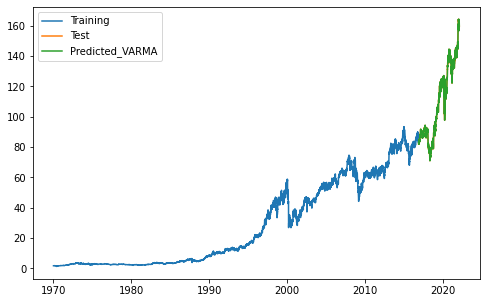

In [45]:
plt.figure(figsize=(8,5))
plt.plot(df[:11830].Close ,label="Training")
plt.plot(df[-1315:].Close ,label="Test")
plt.plot(prediction_rescaled_VARMA.Close, label="Predicted_VARMA")
plt.legend(loc = 'upper left')
plt.show()

In [46]:
evaluate_prediction(prediction_rescaled_VARMA, df[-1315:], 'VARMA')

Open VARMA performance:
R^2: 99.6808 %
Mean Absolute Error: 0.8586
Mean Squared Error: 1.8434
Root Mean Squared Error: 1.3577
Max_error: 14.6220

High VARMA performance:
R^2: 99.7750 %
Mean Absolute Error: 0.7648
Mean Squared Error: 1.3270
Root Mean Squared Error: 1.1520
Max_error: 8.3112

Low VARMA performance:
R^2: 99.7290 %
Mean Absolute Error: 0.8047
Mean Squared Error: 1.5413
Root Mean Squared Error: 1.2415
Max_error: 9.7593

Close VARMA performance:
R^2: 99.6600 %
Mean Absolute Error: 0.8859
Mean Squared Error: 1.9676
Root Mean Squared Error: 1.4027
Max_error: 12.2116

Adj Close VARMA performance:
R^2: 99.7527 %
Mean Absolute Error: 0.8314
Mean Squared Error: 1.7673
Root Mean Squared Error: 1.3294
Max_error: 11.6370

Volume VARMA performance:
R^2: -12.5431 %
Mean Absolute Error: 2235731.6617
Mean Squared Error: 14056333265459.9004
Root Mean Squared Error: 3749177.6786
Max_error: 30487879.4077

